# OSSEs for SWOT Adopt-a-Crossover

This notebook enables a user to select an AdAC region and sampling trajectory (e.g., the path of an ocean glider or a ship-based underway CTD), and then does the following:
* download llc4320 data to the local machine
* compute steric height and potential vorticity 
* interpolate model fields in space/time over the trajectory
* return set of subsampled variables 
* store and plot outputs, including "true" versus "sampled" steric height 

### User inputs:
* **RegionName**: name of region (corresponding to filename) - options are WesternMed  ROAM_MIZ  NewCaledonia  NWPacific  BassStrait  RockallTrough  ACC_SMST MarmaraSea  LabradorSea  CapeBasin
* **start_date**, **ndays**: specify date range as start date & number of days.
* **SAMPLING_STRATEGY** : select whether you want to sample the model using a simulated glider track (`sim_glider`), a simulated underway ctd (`sim_uctd`), or a user-specified trajectory (`trajectory_file`), in which case **trajectory_file** must also be specified
* **PATTERN**: survey pattern -- can be `lawnmower` or `back-forth`
* **datadir** : directory where data files are stored



### Future developments to include:
* cloud version
* derivation of other variables
* piping output into optimal interpolations
* implement other models (e.g., regional simulations)


Led by Kyla Drushka (kdrushka@apl.uw.edu) and developed in part during OceanHackWeek21 with team Dhruv Balwada, Cassia Cai, Diana LaScala-Gruenewald and Iury Simoes-Sousa.

In [100]:
## Imports

# Native packages
from math import radians, degrees, sin, cos, asin, acos, sqrt
import datetime
import sys


# Third-party packages for data manipulation
import numpy as np
import pandas as pd
import xarray as xr

# Third-party packages for data interpolation
from scipy import interpolate
from xgcm import Grid

# Third-party packages for data visualizations
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d

# define functions:

# osse tools package:
# del sys.modules['osse_tools'] 
from osse_tools import download_llc4320_data, compute_derived_fields, get_sampling_trajectory

# dask:
import dask
from dask.diagnostics import ProgressBar
from dask.distributed import Client
client = Client()
display(client)

/home/kdrushka/miniconda3/envs/py33/lib/python3.9/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42163 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:34787 Dashboard: http://127.0.0.1:42163/status,Cluster Workers: 4 Cores: 8 Memory: 31.31 GiB


In [192]:
# --------------------------------------------------------------------
# USER INPUTS:
# --------------------------------------------------------------------

# specify region from this list:
# WesternMed  ROAM_MIZ  NewCaledonia  NWPacific  BassStrait  RockallTrough  ACC_SMST
# MarmaraSea  LabradorSea  CapeBasin
RegionName = 'ACC_SMST' 

# specify date range as start date & number of days.
start_date = datetime.date(2012,1,1)
ndays = 31

# directory where data files are stored
# datadir = './data/' # default is ./data
datadir = '/data1/adac/mitgcm/netcdf/' + RegionName +'/'

## Set sampling strategy
# options: sim_glider, sim_uctd or trajectory_file
SAMPLING_STRATEGY = 'sim_glider'

# optional details for sampling (if not specified, reasonable defaults will be used)
sampling_details = {
    'PATTERN' : 'lawnmower', # back-forth or lawnmower 
    'zrange' : [-1, -1000],  # depth range of profiles (down is negative)
    'hspeed' : 0.25,  # platform horizontal speed in m/s
    'vspeed' : 0.1, # platform vertical (profile) speed in m/s 
    'trajectory_file' : None # if SAMPLING_STRATEGY = 'trajectory_file', specify trajectory file
}

# --------------------------------------------------------------------

#### Download & load model data and derived fields

Based on [LLC4320](https://data.nas.nasa.gov/viz/vizdata/llc4320/index.html), the 1/48-degree global MITgcm simulation produced by the ECCO project. Ten regional cut-outs of the simulation are available on the [PO.DAAC](https://podaac.jpl.nasa.gov/datasetlist?ids=Processing+Levels&values=4+-+Gridded+Model+Output&search=Pre-SWOT+llc4320&view=list&provider=); the 4x4 degree regional domains are small enough to enable fairly easy downloads and processing. The data from the model were retrieved using download_llc4320.ipynb and saved locally.

In [ ]:
# download files:
download_llc4320_data(RegionName, datadir, start_date, ndays)

# derive & save new files with steric height & vorticity
compute_derived_fields(RegionName, datadir, start_date, ndays)

# Load all model data files  
date_list = [start_date + datetime.timedelta(days=x) for x in range(ndays)]
target_files = [f'{datadir}LLC4320_pre-SWOT_{RegionName}_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files
ds = xr.open_mfdataset(target_files, parallel=True)

# load the corresponding derived fields
derivedir = datadir + 'derived/'
derived_files = [f'{derivedir}LLC4320_pre-SWOT_{RegionName}_derived-fields_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files
dsd = xr.open_mfdataset(derived_files)

# merge the derived and raw data
ds = ds.merge(dsd)

#### Make some manipulations to the coordinates to make life easier
*  Change time from datetime to integer
* LLC4320 data does not have lat, lon as coordinates; instead the coordinates are simply index numbers. This means that the lon-lat-depth passed for the trajectory will have to be converted to the corresponding index numbers - we do this by creating interpolation functions f_x, f_y, f_z


In [35]:
# Change time from datetime to integer
ds = ds.assign_coords(time=np.linspace(0,ds.time.size-1, num=ds.time.size)) # time is now in hours

# Convert lon, lat and z to index i, j and k with f_x, f_y and f_z
# XC, YC and Z are the same at all times, so select a single time
X = ds.XC.isel(time=0) 
Y = ds.YC.isel(time=0)
i = ds.i
j = ds.j
z = ds.Z.isel(time=0)
k = ds.k
f_x = interpolate.interp1d(X[0,:].values, i)
f_y = interpolate.interp1d(Y[:,0].values, j)
f_z = interpolate.interp1d(z, k, bounds_error=False)

# Get boundaries and center of model region
model_boundary_n = Y.max().values
model_boundary_s = Y.min().values
model_boundary_w = X.min().values
model_boundary_e = X.max().values
model_xav = ds.XC.isel(time=0, j=0).mean(dim='i').values
model_yav = ds.YC.isel(time=0, i=0).mean(dim='j').values

#### Create & visualize the sampling pattern, and interpolate:

In [210]:
del sys.modules['osse_tools'] 
from osse_tools import download_llc4320_data, compute_derived_fields, get_sampling_trajectory
survey_track, survey_indices, sdata, sh_true = get_sampling_trajectory(ds, SAMPLING_STRATEGY, sampling_details)

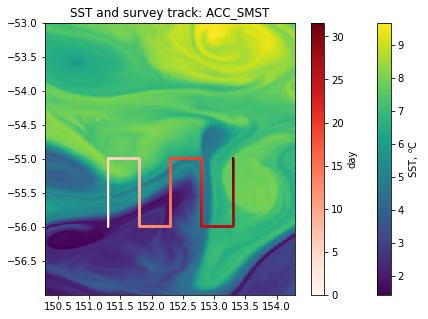

In [207]:
## Visualize track over a single model snapshot:
%matplotlib inline
plt.figure(figsize=(7,5))
ssto = plt.pcolormesh(X,Y,ds.Theta.isel(k=0, time=0).values, shading='auto')
tracko = plt.scatter(survey_track.lon, survey_track.lat, c=survey_track.time, cmap='Reds', s=0.75)
plt.title('SST and survey track: ' + RegionName)
plt.colorbar(ssto).set_label('SST, $^o$C')
plt.colorbar(tracko).set_label('day')
plt.show()

### Visualize interpolated data in 3D

In [208]:
%matplotlib qt

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
fig.subplots_adjust(left=0.25, bottom=0.25)

ax.set_xlabel('longitude', fontsize=15, rotation=150)
ax.set_ylabel('latitude',fontsize=15)
ax.set_zlabel('depth', fontsize=15, rotation=60)

p = ax.scatter3D(sdata.lon.data, sdata.lat.data, sdata.dep.data, c=sdata.Theta.data, s=1)
fig.colorbar(p)
ax.set_title('Temperature ($^o$C) interpolated to the survey track')

Text(0.5, 0.92, 'Temperature ($^o$C) interpolated to the survey track')

Text(0, 0.5, 'depth, m')

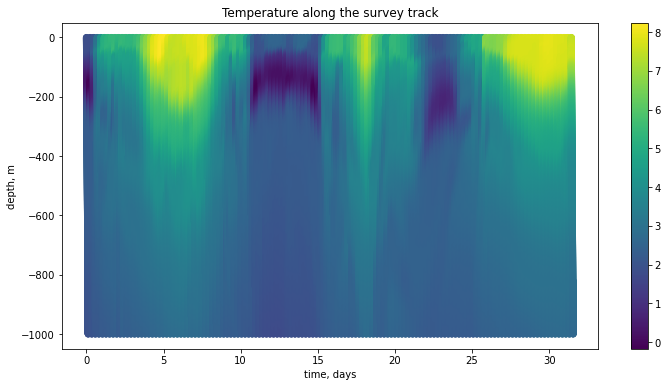

In [215]:
## Visualize a section as a function of time/depth
%matplotlib inline
fig = plt.figure(figsize=(12, 6))
plt.scatter(sdata.time, sdata.dep, c=sdata.Theta.data)
plt.title('Temperature section along the survey track')
plt.colorbar()
plt.xlabel('time, days')
plt.ylabel('depth, m')

### Visualize steric height
Plot comparing the "true" steric height along the track and the subsampled steric height, which is computed by integrating each subsampled profile from its deepest sampling depth

In [ ]:
## Create a new dataset to contain the interpolated data and interpolate

%matplotlib inline

subsampled_data = xr.Dataset() # NOTE: add more metadata to this dataset?
subsampled_data['Theta']=ds.Theta.interp(survey_indices) # NOTE: is there a smarter way to do this using variable names and a loop?
subsampled_data['Salt']=ds.Salt.interp(survey_indices) 
# # /// for steric height we actually just want to interpolate to the 2-d track location, not the exact glider locations!!
subsampled_data['steric_height']=ds.steric_height.interp(survey_indices) 
subsampled_data['vorticity']=ds.vorticity.interp(survey_indices) 

subsampled_data['lon']=survey_track.lon
subsampled_data['lat']=survey_track.lat
subsampled_data['dep']=survey_track.dep
subsampled_data['time']=survey_track.time


In [ ]:
# 2-d interpolation of steric height "truth" - just along the surevy track, full depth interpolation
survey_indices_2d =  survey_indices.drop_vars('k') # create 2-d survey track by removing the depth dimension
sh_true = ds.steric_height.isel(k=-1).interp(survey_indices_2d) # interpolate full-depth SH (last value of dep, i.e., k=-1) to the 2-d track

Text(0, 0.5, 'steric height anom., m')

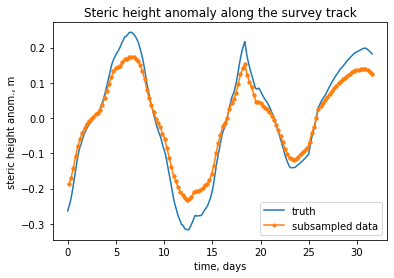

In [216]:
%matplotlib inline

# truth:
plt.plot(sh_true.time, sh_true.values - sh_true.values.mean())
# get index of the deepest sampling depths
i = ( sdata.dep.values == sdata.dep.values.min() )
plt.plot(sdata.time.values[i], sdata.steric_height.values[i] - sdata.steric_height.values[i].mean(),'.-')
plt.title('Steric height anomaly along the survey track')
plt.legend(['truth','subsampled data'])
plt.xlabel('time, days')
plt.ylabel('steric height anom., m')

Text(0, 0.5, 'steric height anom., m')

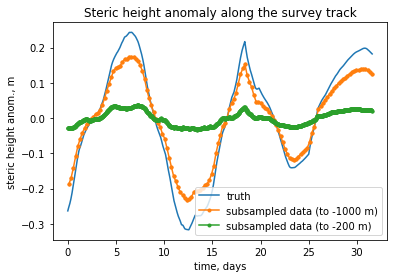

In [217]:
# compare a shallower sampling strategy:
sampling_details_shallow = dict(sampling_details)
sampling_details_shallow['zrange'] = [-1 ,-200]
survey_track_shallow, survey_indices_shallow, sdata_shallow, sh_true_shallow = get_sampling_trajectory(ds, SAMPLING_STRATEGY, sampling_details_shallow)

# truth:
plt.plot(sh_true.time, sh_true.values - sh_true.values.mean())
# get index of the deepest sampling depths
i = ( sdata.dep.values == sdata.dep.values.min() )
plt.plot(sdata.time.values[i], sdata.steric_height.values[i] - sdata.steric_height.values[i].mean(),'.-')
j = ( sdata_shallow.dep.values == sdata_shallow.dep.values.min() )
plt.plot(sdata_shallow.time.values[j], sdata_shallow.steric_height.values[j] - sdata_shallow.steric_height.values[j].mean(),'.-')

plt.title('Steric height anomaly along the survey track')
plt.legend(['truth',r'subsampled data (to %d m)' % sampling_details['zrange'][1],
            r'subsampled data (to %d m)' % sampling_details_shallow['zrange'][1]])

plt.xlabel('time, days')
plt.ylabel('steric height anom., m')
